# TUV-x: Standard Configurations

The [TUV-x photolysis calculator](https://github.com/ncar/tuv-x) is available as part of the MUSICA library. TUV-x can be used to calculate photolysis rate constants for a given set of conditions. It can also be used to calculate exposure metrics ("dose rates" in TUV-x lingo) based on the calculated radiation field.

TUV-x can be configured for any number of photolysis and dose rate calculations. We also provide two standard configurations in the MUSICA Python package:
- v5.4: A TUV-x configuration that corresponds to the original [TUV 5.4 model](https://www2.acom.ucar.edu/modeling/tuv-download)
- vTS1/TSMLT: A TUV-x configuration for use with the MOZART TS1 and TSMLT chemical mechanisms

## $\text{O}_3$ Photolysis Comparison

To get started, we'll use the two standard TUV-x configurations to calculate the rate constants for O3 photolysis. We include rate constants for both $\text{O}_3$ photolysis branches (forming $\text{O(1D)}$ or $\text{O(3P)}$).

In [1]:
from musica.tuvx import v54, vTS1
from musica.tuvx import TUVX
import xarray as xr

v54_calculator: TUVX = v54.get_tuvx_calculator()
vTS1_calculator: TUVX = vTS1.get_tuvx_calculator()

v54_results: xr.Dataset = v54_calculator.run(sza=0.0, earth_sun_distance=1.0)
vTS1_results: xr.Dataset = vTS1_calculator.run(sza=0.0, earth_sun_distance=1.0)


Here, we first load the required dependencies. TUV-x returns results as XArray Datasets, so we also import XArray.

The `get_tuvx_calculator()` functions return fully configured TUV-x instances, loaded with specific rate constant and dose rate algorithms, along with a set of standard environmental conditions (we'll look at these more in a later section). The v5.4 and vTS1/TSMLT configurations include the same set of standard environmental conditions to facilitate comparisons. The environmental conditions and results from TUV-x are for a vertical atmosphere column. The standard conditions use a column with 120 layers of 1-km height per layer. TUV-x can be configured to work with columns with any number of layers.

The `TUVX::run()` function calculates photolysis rate constants and dose rates by first solving the radiation field for the column, and then applying the configured photolysis and dose rate algorithms to the calculated radiation field. The two arguments to the `TUVX::run()` function set the solar zenith angle (`sza`) \[radians\] and the Earth&ndash;Sun Distance(`earth_sun_distance`) \[AU\].

Now, let's compare the results.

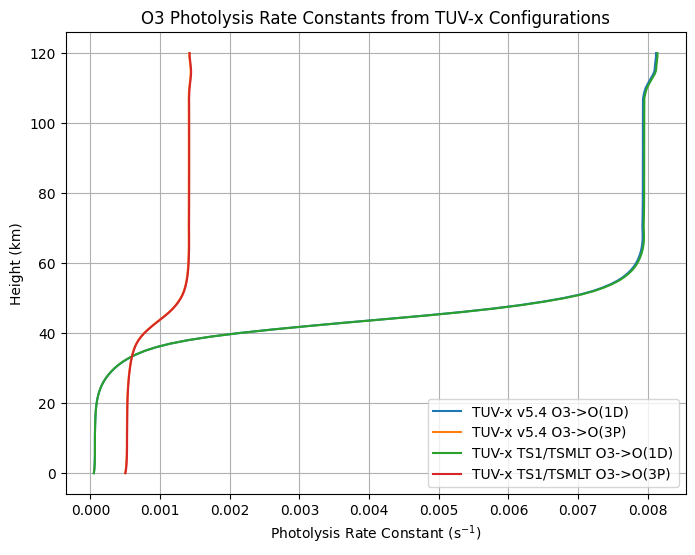

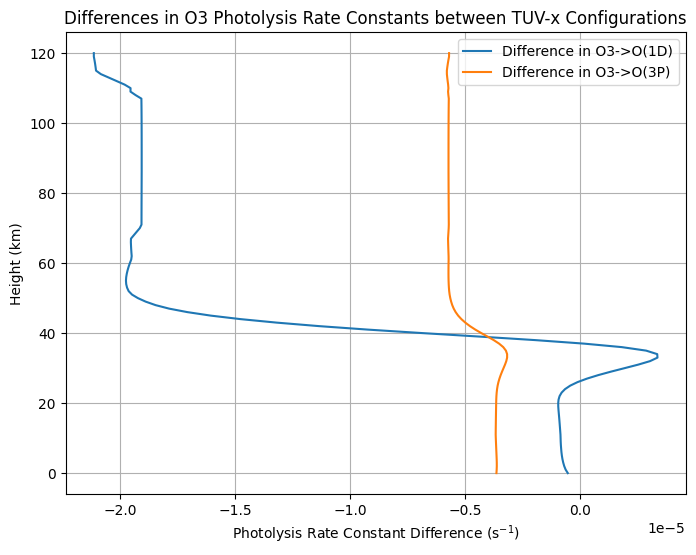

In [2]:
# the labels for the O3 reactions are different in the two configurations
jo3_o1d_v54_label = "O3+hv->O2+O(1D)"
jo3_o3p_v54_label = "O3+hv->O2+O(3P)"
jo3_o1d_vTS1_label = "jo3_a"
jo3_o3p_vTS1_label = "jo3_b"

# get the height and O3 profiles for both sets of results
height_v54 = v54_results["vertical_edge"].values
jo3_o1d_v54 = v54_results["photolysis_rate_constants"].sel(reaction=jo3_o1d_v54_label)
jo3_o3p_v54 = v54_results["photolysis_rate_constants"].sel(reaction=jo3_o3p_v54_label)
height_vTS1 = vTS1_results["vertical_edge"].values
jo3_o1d_vTS1 = vTS1_results["photolysis_rate_constants"].sel(reaction=jo3_o1d_vTS1_label)
jo3_o3p_vTS1 = vTS1_results["photolysis_rate_constants"].sel(reaction=jo3_o3p_vTS1_label)

# plot the comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(jo3_o1d_v54, height_v54, label="TUV-x v5.4 O3->O(1D)")
plt.plot(jo3_o3p_v54, height_v54, label="TUV-x v5.4 O3->O(3P)")
plt.plot(jo3_o1d_vTS1, height_vTS1, label="TUV-x TS1/TSMLT O3->O(1D)")
plt.plot(jo3_o3p_vTS1, height_vTS1, label="TUV-x TS1/TSMLT O3->O(3P)")
plt.xlabel("Photolysis Rate Constant (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("O3 Photolysis Rate Constants from TUV-x Configurations")
plt.legend()
plt.grid()
plt.show()

# plot the differences
plt.figure(figsize=(8, 6))
plt.plot(jo3_o1d_v54 - jo3_o1d_vTS1, height_v54, label="Difference in O3->O(1D)")
plt.plot(jo3_o3p_v54 - jo3_o3p_vTS1, height_v54, label="Difference in O3->O(3P)")
plt.xlabel("Photolysis Rate Constant Difference (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("Differences in O3 Photolysis Rate Constants between TUV-x Configurations")
plt.legend()
plt.grid()
plt.show()

The differences between results for the two configurations are relatively small, and in fact both the v5.4 and vTS1/TSMLT configurations use the same configuration for $\text{O}_3$ photolysis:

```json
         {
            "name": "O3+hv->O2+O(1D)",
            "cross section": {
               "netcdf files": [
                 { "file path": "data/cross_sections/O3_1.nc" },
                 { "file path": "data/cross_sections/O3_2.nc" },
                 { "file path": "data/cross_sections/O3_3.nc" },
                 { "file path": "data/cross_sections/O3_4.nc" }
               ],
               "type": "O3",
               "__output": true
            },
            "quantum yield": {
               "type": "O3+hv->O2+O(1D)"
            }
         },
         {
            "name": "O3+hv->O2+O(3P)",
            "cross section": {
               "netcdf files": [
                 { "file path": "data/cross_sections/O3_1.nc" },
                 { "file path": "data/cross_sections/O3_2.nc" },
                 { "file path": "data/cross_sections/O3_3.nc" },
                 { "file path": "data/cross_sections/O3_4.nc" }
               ],
               "type": "O3",
               "__output": true
            },
            "quantum yield": {
               "type": "O3+hv->O2+O(3P)",
               "__output": true
            }
         }
```

The small differences we do see can be attributed to the differences in the 156- and 102-bin wavelength grids of the v5.4 and vTS1/TSMLT configurations, respectively. Solving the radiation field on differently shaped wavelength grids is expected to lead to differences in the results.

Now, let's look at results for a photolysis rate constant that is configured differently in v5.4 and vTS1/TSMLT, $\text{N}_2\text{O}_5$ photolysis:

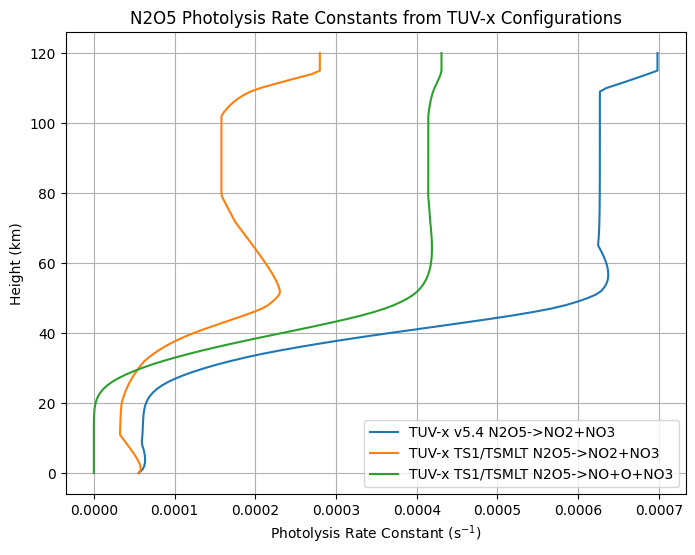

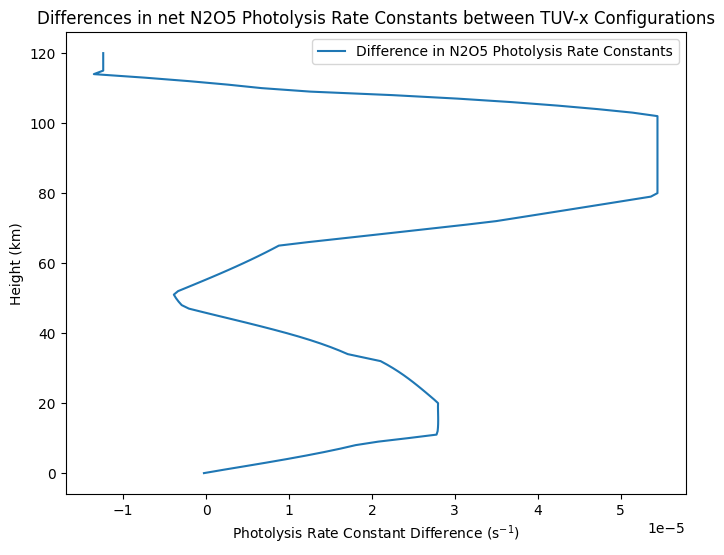

In [3]:
# the labels for the N2O5 reactions are difference in the two configurations
jn2o5_v54_label = "N2O5+hv->NO2+NO3"
jn2o5a_vTS1_label = "jn2o5_a" # N2O5 + hv -> NO2 + NO3
jn2o5b_vTS1_label = "jn2o5_b" # N2O5 + hv -> NO + O + NO3

# get the height and O3 profiles for both sets of results
height_v54 = v54_results["vertical_edge"].values
jn2o5_v54 = v54_results["photolysis_rate_constants"].sel(reaction=jn2o5_v54_label)
height_vTS1 = vTS1_results["vertical_edge"].values
jn2o5a_vTS1 = vTS1_results["photolysis_rate_constants"].sel(reaction=jn2o5a_vTS1_label)
jn2o5b_vTS1 = vTS1_results["photolysis_rate_constants"].sel(reaction=jn2o5b_vTS1_label)

# plot the comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(jn2o5_v54, height_v54, label="TUV-x v5.4 N2O5->NO2+NO3")
plt.plot(jn2o5a_vTS1, height_vTS1, label="TUV-x TS1/TSMLT N2O5->NO2+NO3")
plt.plot(jn2o5b_vTS1, height_vTS1, label="TUV-x TS1/TSMLT N2O5->NO+O+NO3")
plt.xlabel("Photolysis Rate Constant (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("N2O5 Photolysis Rate Constants from TUV-x Configurations")
plt.legend()
plt.grid()
plt.show()

# plot the difference between the single v5.4 rate constant and the sum of the two TS1/TSMLT rate constants
plt.figure(figsize=(8, 6))
plt.plot(jn2o5_v54 - (jn2o5a_vTS1 + jn2o5b_vTS1), height_v54, label="Difference in N2O5 Photolysis Rate Constants")
plt.xlabel("Photolysis Rate Constant Difference (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("Differences in net N2O5 Photolysis Rate Constants between TUV-x Configurations")
plt.legend()


Note that the v5.4 configuration only includes a single pathway for $\text{N}_2\text{O}_5$ photolysis, whereas the vTS1/TSMLT includes two. The rate constant for the single pathway in v5.4 is approximately equal to the combination of the two pathways in vTS1/TSMLT.

## Dose Rates

Let's plot a couple dose rate outputs, as well. The vTS1/TSMLT configuration doesn't include dose rates, as it's primarily designed for use with the MOZART TS1/TSMLT chemical mechanisms, so we'll just plot rates from the v5.4 configuration.

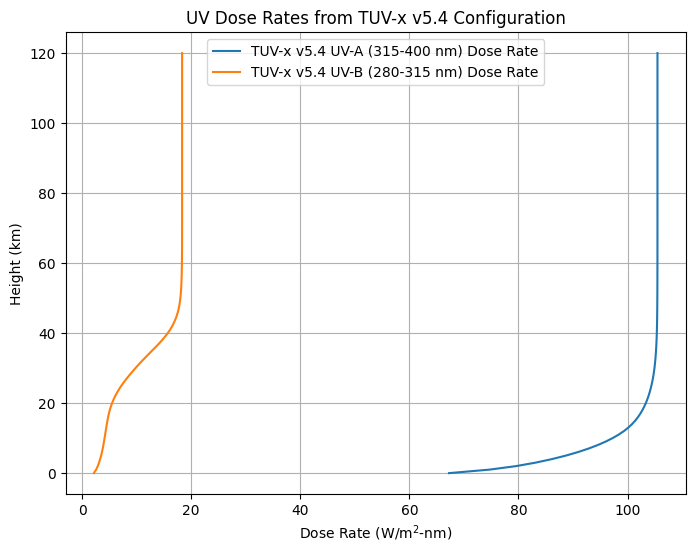

In [4]:
# dose rate labels
uva_label = "UV-A, 315-400 nm"
uvb_label = "UV-B, 280-315 nm"

# dose rates from the v5.4 configuration
uva_v54 = v54_results["dose_rates"].sel(dose_rate=uva_label)
uvb_v54 = v54_results["dose_rates"].sel(dose_rate=uvb_label)

# plot the dose rate profiles
plt.figure(figsize=(8, 6))
plt.plot(uva_v54, height_v54, label="TUV-x v5.4 UV-A (315-400 nm) Dose Rate")
plt.plot(uvb_v54, height_v54, label="TUV-x v5.4 UV-B (280-315 nm) Dose Rate")
plt.xlabel("Dose Rate (W/m$^2$-nm)")
plt.ylabel("Height (km)")
plt.title("UV Dose Rates from TUV-x v5.4 Configuration")
plt.legend()
plt.grid()
plt.show()